In [1]:
import pandas as pd
import socnet as sn
import json
import scipy
import numpy as np
from itertools import permutations
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

fp = open('network_cleaned_data.json', 'r')
players = json.load(fp)

In [2]:
print(len(players))

238


In [3]:
def create_gml():
    gml = open("players.gml", "w")
    gml.write("graph [\n  directed 1\n  weighted 1\n")
    for player in players:
        gml.write('  node [\n    id {}\n    label "{}"\n  ]\n'.format(player, str(player)))
    for player in players:
        for team_mate, times_played in players[player]["team_mates"].items():
            gml.write("  edge [\n    source {}\n    target {}\n    weight {}\n  ]\n".format(player, team_mate, times_played))
    gml.write("]")
    gml.close()
create_gml()

In [4]:
sn.node_size = 10
sn.node_color = (255, 255, 255)

sn.edge_width = 1
sn.edge_color = (192, 192, 192)

sn.node_label_position = 'hover'
g = sn.load_graph('players.gml', has_pos=False)
g = g.to_undirected()
sn.show_graph(g, nlab=True)

In [5]:
for n in g.nodes:
    g.nodes[n]['mean_rating'] = players[str(n)]["mean_rating"]
    g.nodes[n]['played_teams'] = players[str(n)]["teams"]
bet = nx.betweenness_centrality(g)
close = nx.closeness_centrality(g)
mean_rating_camp = [list(players[p]['mean_rating_campeonato'].values()) for p in players]
df = pd.DataFrame({
    'id': [n for n in bet],
    'betweenness': [bet[n] for n in bet],
    'closeness': [close[n] for n in close],
    'mean_rating': [g.nodes[n]['mean_rating'] for n in g.nodes],
    'played_teams': [g.nodes[n]['played_teams'] for n in g.nodes],
    'mean_rating_camp': mean_rating_camp    
})

In [6]:
df['camps_played'] = df['mean_rating_camp'].str.len()
df['played_teams_count'] = df['played_teams'].str.len()
# df = df[df['camps_played'] >= 4]
df.sort_values(by=['camps_played'], ascending=False)

,id,betweenness,closeness,mean_rating,played_teams,mean_rating_camp,camps_played,played_teams_count
34,22078,0.012154,0.379808,1.064906,"[9216, 3839]","[1.251, 1.031, 1.095, 0.473, 1.011, 0.957, 1.1...",9,2
32,120,0.036902,0.407216,1.041109,"[9216, 57163, 3839, 57623, 28767, 102601]","[1.109, 1.05, 0.826, 1.22, 0.955, 1.018, 1.015...",9,6
31,17360,0.010667,0.377389,0.993833,"[9216, 71225]","[1.201, 0.815, 1.204, 0.927, 1.008, 0.914, 0.9...",9,2
114,25,0.030636,0.427798,1.153833,"[71225, 11690, 7688, 102601]","[1.25, 1.34, 1.18, 1.149, 0.995, 1.207, 1.064,...",9,4
30,16540,0.010114,0.369159,1.090630,"[9216, 7688, 71225]","[1.213, 1.412, 1.196, 0.579, 1.01, 0.857, 1.08...",9,3
27,75566,0.033933,0.420959,1.011520,"[11805, 9216, 29149, 57623]","[1.028, 1.009, 1.129, 0.625, 1.191, 1.022, 1.0...",9,4
95,30845,0.024343,0.401695,0.873656,"[11690, 71225, 75379]","[0.894, 1.025, 0.663, 0.874, 0.946, 0.726, 0.9...",8,3
37,25295,0.036050,0.420213,0.963788,"[28767, 7688, 63816]","[1.048, 0.966, 1.374, 0.753, 0.862, 0.921, 1.0...",8,3
69,13652,0.058633,0.416520,0.955432,"[37864, 28767, 71225, 63816]","[0.965, 1.047, 0.85, 1.042, 1.087, 1.008, 0.83...",8,4
120,171,0.013796,0.369735,1.180260,"[3838, 76382]","[1.245, 0.972, 0.909, 1.064, 1.277, 1.205, 1.1...",8,2


In [7]:
# df.describe()

In [14]:
bet = []
clo = []
for i in range(9):
    df2 = df[df['camps_played'] >= i]
    bet.append(df2["betweenness"].corr(df2["mean_rating"]))
    clo.append(df2["closeness"].corr(df2["mean_rating"]))

print(bet)
print(" ")
print(clo)

[0.13417912347787733, 0.13417912347787733, -0.06835803079716486, -0.2531227887489602, -0.29090753023784727, -0.2962207038804781, -0.29796614327903803, -0.2326926721024259, -0.3860244663414227]
 
[0.38168332103160363, 0.38168332103160363, 0.2794678275282935, 0.04072715081989074, 0.12630624330433818, 0.21365267650548858, 0.21571814680704018, 0.2852285640141704, -0.31230291724474685]


In [9]:
df["betweenness"].corr(df["mean_rating"])

0.13417912347787733

In [10]:
df["closeness"].corr(df["mean_rating"])

0.38168332103160363

/home/martim/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



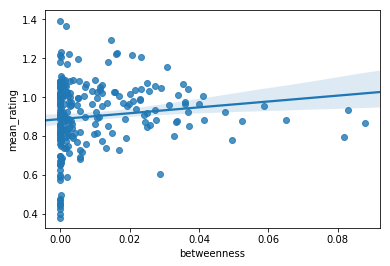

In [11]:
sns.regplot(x="betweenness", y="mean_rating", data=df);

In [12]:
test = scipy.stats.ttest_rel(df2["betweenness"], df2["mean_rating"])
print(test[1])
print("P-Value Betweenness x Mean_Rating: ", np.around(test[1],decimals=20))

8.132037143745593e-32
P-Value Betweenness x Mean_Rating:  0.0


In [13]:
test = scipy.stats.ttest_rel(df["closeness"], df["mean_rating"])
print(test[1])
print("P-Value Closeness x Mean_Rating: ", np.around(test[1],decimals=20))

7.231586760614504e-140
P-Value Closeness x Mean_Rating:  0.0
